<a href="https://colab.research.google.com/github/farahinamir/Master-Project/blob/main/Unsupervised_ML_Health_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#C0DDD1; color: #1D3037; overflow:hidden"><b> Sentiment Analysis for Mental Health </b></div>

<a id="libraries"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 1. Importing Required Libraries </b></div>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

<a id="data"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 2. Reading and Understanding our Data </b></div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', index_col=0, engine='python', on_bad_lines='skip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Removing missing data

In [ ]:
df.isna().sum()

,0
statement,362
status,0


In [ ]:

df.dropna(inplace = True)
df.isna().sum()

,0
statement,0
status,0


### Looking at target variable

In [ ]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


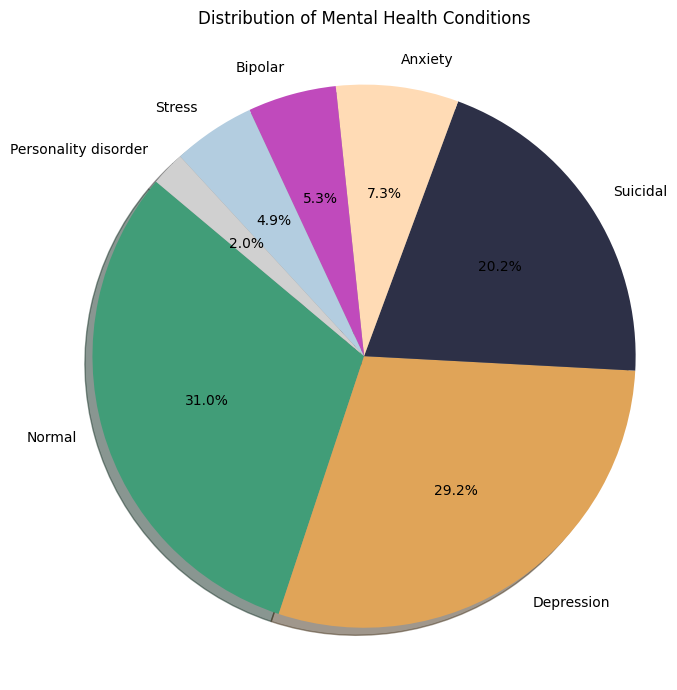

In [ ]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        The target variable in our dataset is <strong>unbalanced</strong>. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions.
    </ul>
</div>

### Looking at raw texts

In [ ]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Xanax after drinking hald a glass of wine (~3oz) I'm pretty sure this is okay, but I wanted to reach out and make sure. I'm prescribed xanax and my Dr told me to take it 3-6 hours after drinking if I've drank. I had some red wine (about 3oz) It's been under three hours but i'm very anxious and can't handle it haha- so I took .25mg (half of my usual dose) will I be ok?

Status: Bipolar
Statement: Raising a child as a bipolar parent How do you raise a child when you are going through a depressive phase and you can't even take care of yourself, much less a 5 year old?  My wife left us a year ago, and I haven't even had the time to deal with that shit.  My daughter constantly needs me to be there for her but half the time, I just want to pull the covers over my head and hide.  I don't get enough sleep and I'm always fearful I'm going to enter into manic mode.  I feel like a failure as a dad for having the constant changes in mood that come with bipolar.  I take m

### Adding new features

In [ ]:
import nltk
# Download the necessary resource for sentence tokenization
nltk.download('punkt_tab')
nltk.download('punkt')

# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        We have several lengthy messages, most of which express suicidal thoughts or signs of depression:
    </ul>
</div>

In [ ]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


<a id="preprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 3. Text Preprocessing </b></div>

## 3.1. Lowercasing

Convert all statements to lowercase to ensure uniformity.

In [ ]:
# Removing missing data (as done previously)
df.dropna(inplace = True)

# Add numerical features again (as done previously)
import nltk
nltk.download('punkt_tab') # Ensure necessary resources are downloaded
nltk.download('punkt')
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))


# Proceed with the renaming and lowercasing as intended
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement']=df['original_statement'].str.lower()
df.head()

# Continue with the rest of your preprocessing steps as they were
# ... (remove_patterns, tokenization, stemming, etc.)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


## 3.2. Removing URLs, handles, punctuation and special characters

To remove specific patterns such as URLs or other unwanted text (like ```[View Poll](https://www.reddit.com/poll/...)```) from a column in a pandas DataFrame, we can use regular expressions with the re module or pandas built-in string methods.

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [ ]:
df['statement'].replace('', np.nan, inplace=True)

print("Count of missing values (NaN or empty strings）:", df['statement'].isna().sum())

df.dropna(subset=['statement'], inplace=True)

df.reset_index(drop=True, inplace=True)

print("Rows removed during cleaning:", len(df))
df.head()


Count of missing values (NaN or empty strings）: 5
Rows removed during cleaning: 52676


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


## 3.3. Tokenization

Split text into individual words or tokens.

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


## 3.4. Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

- happy
- happiness
- happier

We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.

In [ ]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


In [ ]:
print("Missing values (NaN+empty)）:", df['tokens_stemmed'].isna().sum())

df.dropna(subset=['tokens_stemmed'], inplace=True)

df.reset_index(drop=True, inplace=True)

print("Cleaned row count:", len(df))
df.head()


Missing values (NaN+empty)）: 0
Cleaned row count: 52676


,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


## 3.5. Stop Words

While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

##  3.6. Word Clouds

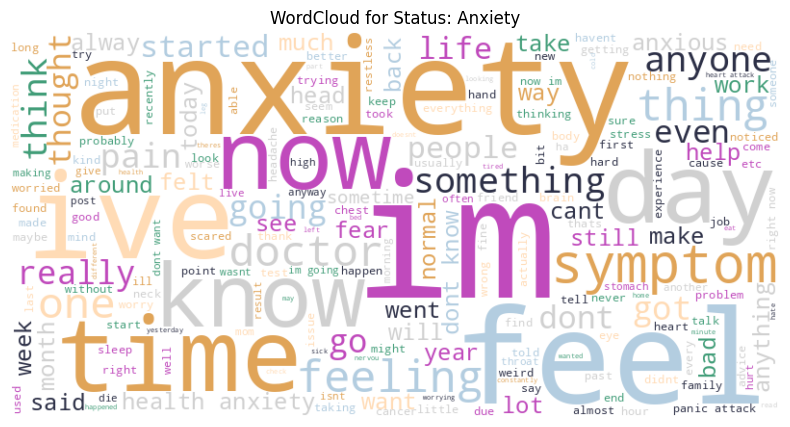

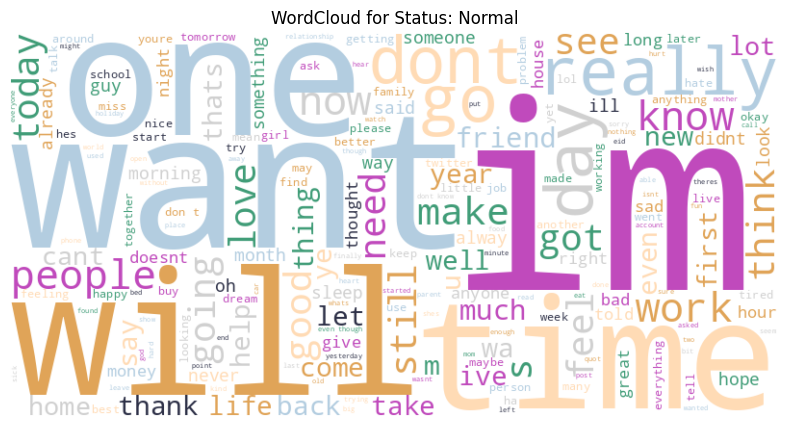

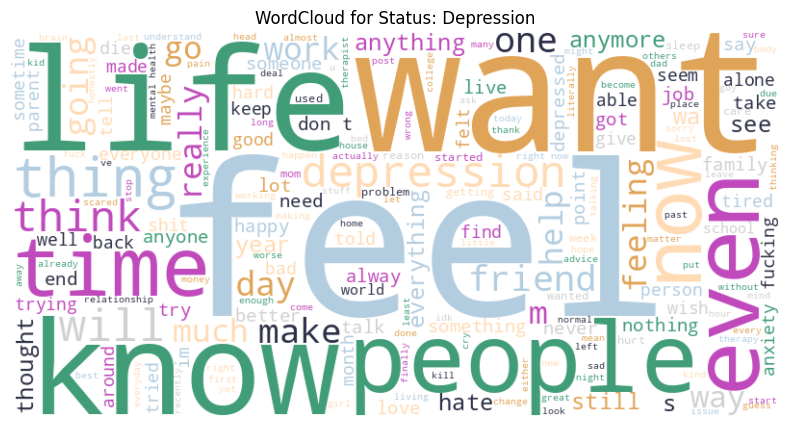

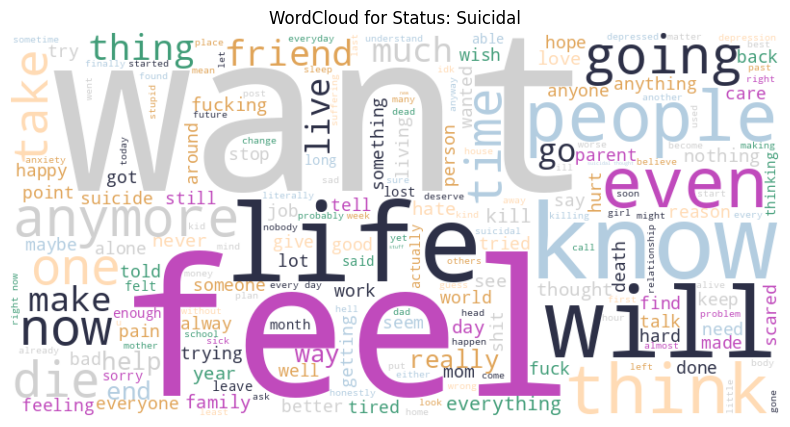

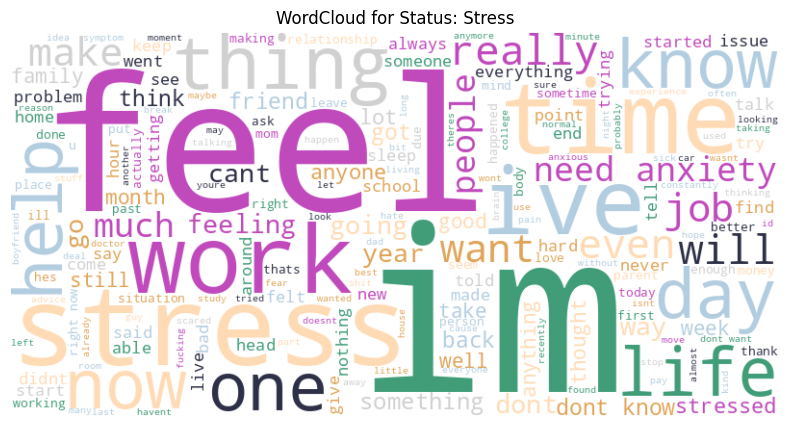

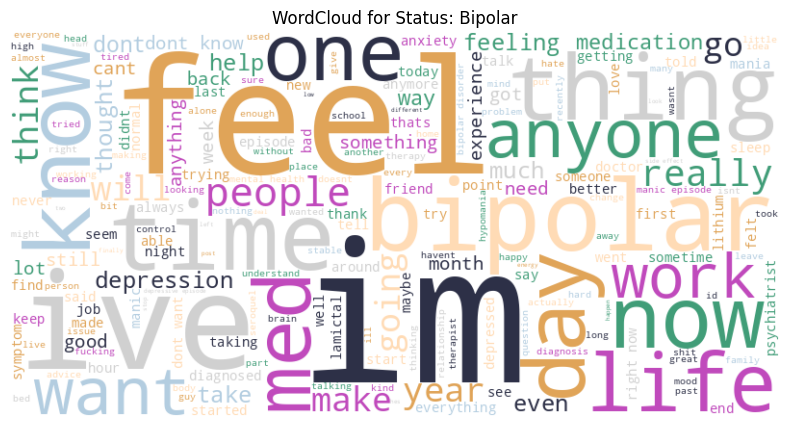

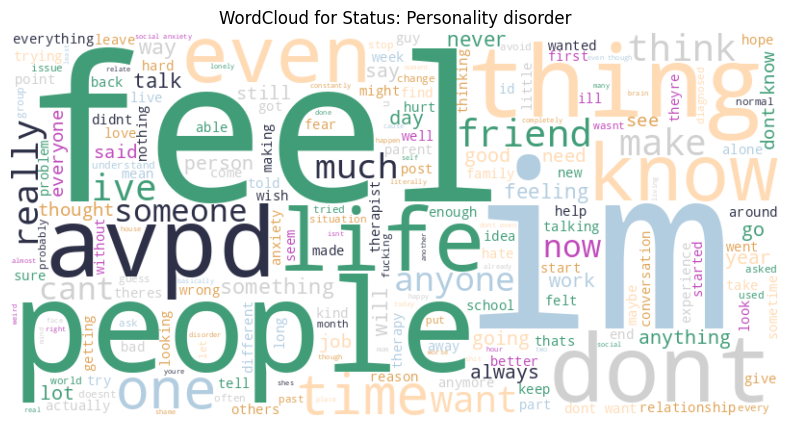

In [ ]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()


<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        There is a significant overlap in the language used for discussing depression and suicidal thoughts in our data. Many terms and phrases are used interchangeably or similarly for both conditions, which may complicate the distinction between them.
    </ul>
</div>

<a id="datapreprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 4. Data Preprocessing </b></div>

In [ ]:
df1=df
df1

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...
...,...,...,...,...,...,...,...
52671,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,1766,16,nobody takes me seriously ive 24m dealt with d...,"[nobody, takes, me, seriously, ive, 24m, dealt...",nobodi take me serious ive 24m dealt with depr...
52672,"selfishness ""I don't feel very good, it's lik...",Anxiety,1012,12,selfishness i dont feel very good its like i ...,"[selfishness, i, dont, feel, very, good, its, ...",selfish i dont feel veri good it like i dont b...
52673,Is there any way to sleep better? I can't slee...,Anxiety,85,2,is there any way to sleep better i cant sleep ...,"[is, there, any, way, to, sleep, better, i, ca...",is there ani way to sleep better i cant sleep ...
52674,"Public speaking tips? Hi, all. I have to give ...",Anxiety,401,6,public speaking tips hi all i have to give a p...,"[public, speaking, tips, hi, all, i, have, to,...",public speak tip hi all i have to give a prese...


## 4.1. Separate features and labels

In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

## 4.2. Label encoding target variable

In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [ ]:
df_combined = pd.concat([X, pd.Series(y, name='label')], axis=1)
df_clean = df_combined.dropna(subset=['tokens_stemmed', 'label'])
print("Class distribution after cleaning:")
print(df_clean['label'].value_counts())


Class distribution after cleaning:
label
3    16339
2    15404
6    10651
0     3841
1     2777
5     2587
4     1077
Name: count, dtype: int64


In [ ]:
min_count = df_clean['label'].value_counts().min()
df_balanced = df_clean.groupby('label').apply(lambda x: x.sample(min_count, random_state=101)).reset_index(drop=True)
min_count = df_clean['label'].value_counts().min()

# Downsample each class to min_count
df_balanced = df_clean.groupby('label').apply(
    lambda x: x.sample(min_count, random_state=42)
).reset_index(drop=True)


## 4.5. Separate Features and Labels Again

In [ ]:
X = df_balanced[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df_balanced['label']


## 4.6.Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 4.7.TF-IDF Vectorization + Numeric Features

Now, we will transform tokens (words) into numerical values that represent the importance of words in a document relative to a collection of documents. This helps highlight unique words in a document while downplaying common ones, making it easier for machine learning models to identify relevant patterns and make better predictions.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = tfidf.transform(X_test['tokens_stemmed'])

# Numeric features
X_train_num = csr_matrix(X_train[['num_of_characters', 'num_of_sentences']].values)
X_test_num = csr_matrix(X_test[['num_of_characters', 'num_of_sentences']].values)

# Final combined feature matrix
X_train_final = hstack([X_train_tfidf, X_train_num])
X_test_final = hstack([X_test_tfidf, X_test_num])


In [ ]:
print("Balanced label distribution:")
print(df_balanced['label'].value_counts())
print("Missing values per column:")
print(df_clean.isna().sum())

Balanced label distribution:
label
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64
Missing values per column:
tokens_stemmed       0
num_of_characters    0
num_of_sentences     0
label                0
dtype: int64


## 4.6. Divide training set and validation set


<a id="model"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 5. Model Traning and Evaluation </b></div>

In [ ]:
!pip install transformers datasets accelerate
!pip install scikit-learn seaborn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Combined Data.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/Combined Data.csv'

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Rename columns to English equivalents
df = df.rename(columns={'statement': 'stemmed_tokens', 'status': 'raw_label'})

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the raw labels into numerical labels (Anxiety -> 0, etc.)
df['label'] = label_encoder.fit_transform(df['raw_label'])

# Create a clean DataFrame with only the stemmed tokens and numerical labels
df_clean = df[['stemmed_tokens', 'label']].copy()

# Print the mapping from original labels to encoded numerical labels
print("Label encoding mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Display the first few rows of the cleaned DataFrame
print(df_clean.head())


Label encoding mapping: {'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}
                                      stemmed_tokens  label
0                                         oh my gosh      0
1  trouble sleeping confused mind restless heart ...      0
2  all wrong back off dear forward doubt stay in ...      0
3  ive shifted my focus to something else but im ...      0
4  im restless and restless its been a month now ...      0


label
3    16339
2    15404
6    10651
0     3841
1     2777
5     2587
4     1077
Name: count, dtype: int64


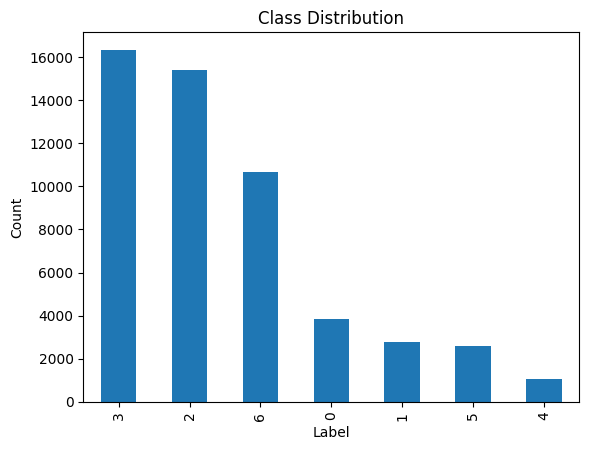

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


label_counts = df['label'].value_counts()
print(label_counts)


label_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

label
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64


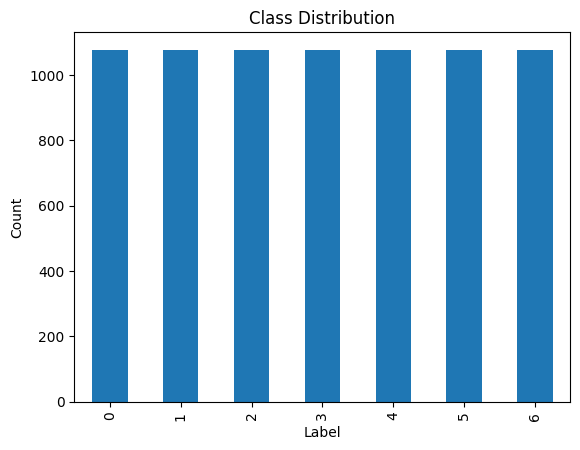

,original_statement,raw_label,num_of_characters,num_of_sentences,stemmed_tokens,tokens,tokens_stemmed,label
0,Is this health anxiety? 1) checking temperatur...,Anxiety,173,2,is this health anxiety 1 checking temperature ...,"[is, this, health, anxiety, 1, checking, tempe...",is thi health anxieti 1 check temperatur 10 ti...,0
1,Is there any way to sleep better? I can't slee...,Anxiety,85,2,is there any way to sleep better i cant sleep ...,"[is, there, any, way, to, sleep, better, i, ca...",is there ani way to sleep better i cant sleep ...,0
2,Lamictal ? Anyone with good reviews about lami...,Anxiety,51,2,lamictal anyone with good reviews about lamictal,"[lamictal, anyone, with, good, reviews, about,...",lamict anyon with good review about lamict,0
3,Has anyone tried EMDR therapy? I just started....,Anxiety,163,5,has anyone tried emdr therapy i just started i...,"[has, anyone, tried, emdr, therapy, i, just, s...",ha anyon tri emdr therapi i just start if so w...,0
4,would my may2018 ECG of picked this up? worrie...,Anxiety,1392,9,would my may2018 ecg of picked this up worried...,"[would, my, may2018, ecg, of, picked, this, up...",would my may2018 ecg of pick thi up worri so y...,0
...,...,...,...,...,...,...,...,...
7534,I experience breakdowns everyday. Even when in...,Suicidal,138,4,i experience breakdowns everyday even when in ...,"[i, experience, breakdowns, everyday, even, wh...",i experi breakdown everyday even when in my dr...,6
7535,Sex dreams are my least favorite dreams. Like ...,Suicidal,142,2,sex dreams are my least favorite dreams like t...,"[sex, dreams, are, my, least, favorite, dreams...",sex dream are my least favorit dream like they...,6
7536,Just some 26 year old lonely dude. Getting rea...,Suicidal,162,4,just some 26 year old lonely dude getting real...,"[just, some, 26, year, old, lonely, dude, gett...",just some 26 year old lone dude get realli tir...,6
7537,i feel foolish for posting here. well. not muc...,Suicidal,1647,32,i feel foolish for posting here well not much ...,"[i, feel, foolish, for, posting, here, well, n...",i feel foolish for post here well not much i c...,6


In [ ]:
from sklearn.utils import resample


min_count = df['label'].value_counts().min()


df_balanced = (
    df.groupby('label')
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)
import pandas as pd
import matplotlib.pyplot as plt


label_counts = df_balanced['label'].value_counts()
print(label_counts)


label_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
df_balanced

label
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64


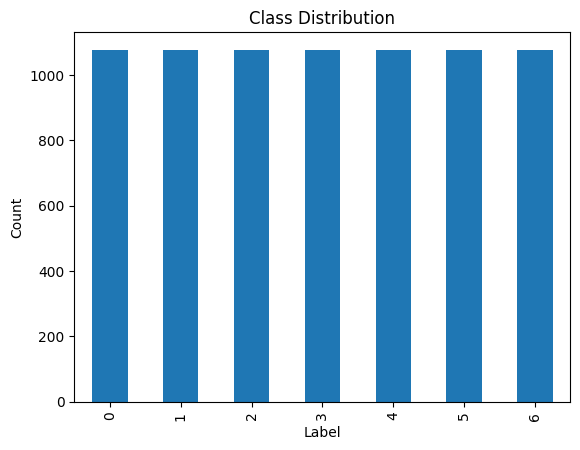

,original_statement,raw_label,num_of_characters,num_of_sentences,stemmed_tokens,tokens,tokens_stemmed,label
0,Is this health anxiety? 1) checking temperatur...,Anxiety,173,2,is this health anxiety 1 checking temperature ...,"[is, this, health, anxiety, 1, checking, tempe...",is thi health anxieti 1 check temperatur 10 ti...,0
1,Is there any way to sleep better? I can't slee...,Anxiety,85,2,is there any way to sleep better i cant sleep ...,"[is, there, any, way, to, sleep, better, i, ca...",is there ani way to sleep better i cant sleep ...,0
2,Lamictal ? Anyone with good reviews about lami...,Anxiety,51,2,lamictal anyone with good reviews about lamictal,"[lamictal, anyone, with, good, reviews, about,...",lamict anyon with good review about lamict,0
3,Has anyone tried EMDR therapy? I just started....,Anxiety,163,5,has anyone tried emdr therapy i just started i...,"[has, anyone, tried, emdr, therapy, i, just, s...",ha anyon tri emdr therapi i just start if so w...,0
4,would my may2018 ECG of picked this up? worrie...,Anxiety,1392,9,would my may2018 ecg of picked this up worried...,"[would, my, may2018, ecg, of, picked, this, up...",would my may2018 ecg of pick thi up worri so y...,0
...,...,...,...,...,...,...,...,...
7534,I experience breakdowns everyday. Even when in...,Suicidal,138,4,i experience breakdowns everyday even when in ...,"[i, experience, breakdowns, everyday, even, wh...",i experi breakdown everyday even when in my dr...,6
7535,Sex dreams are my least favorite dreams. Like ...,Suicidal,142,2,sex dreams are my least favorite dreams like t...,"[sex, dreams, are, my, least, favorite, dreams...",sex dream are my least favorit dream like they...,6
7536,Just some 26 year old lonely dude. Getting rea...,Suicidal,162,4,just some 26 year old lonely dude getting real...,"[just, some, 26, year, old, lonely, dude, gett...",just some 26 year old lone dude get realli tir...,6
7537,i feel foolish for posting here. well. not muc...,Suicidal,1647,32,i feel foolish for posting here well not much ...,"[i, feel, foolish, for, posting, here, well, n...",i feel foolish for post here well not much i c...,6


In [ ]:
from sklearn.utils import resample
# Find the number of samples in the smallest class
min_count = df['label'].value_counts().min()
# Sample according to each class
df_balanced = (
    df.groupby('label')
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)
import pandas as pd
import matplotlib.pyplot as plt
# View the number of samples in each class
label_counts = df_balanced['label'].value_counts()
print(label_counts)
# Visualize class distribution (optional)
label_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
df_balanced

In [ ]:
df_balanced['text'] = df_balanced['stemmed_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
print(df_balanced.dtypes)


original_statement    object
raw_label             object
num_of_characters      int64
num_of_sentences       int64
stemmed_tokens        object
tokens                object
tokens_stemmed        object
label                  int64
text                  object
dtype: object


In [ ]:
import pandas as pd
from sklearn.utils import resample
# Read or use an existing DataFrame
# df_balanced = pd.read_csv('your_file.csv')  # If not loaded yet
# 1. Keep only the required columns
df = df_balanced[['text', 'label']]
# 2. Delete missing values
df = df.dropna()
# 3. Group by label and find the number of samples in the smallest class
min_count = df['label'].value_counts().min()
# 4. Downsample each class
df_balanced_undersampled = (
    df.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)
# 5. View the results
print("Number of samples per class:")
print(df_balanced_undersampled['label'].value_counts())
print("\nNew dataset size:", df_balanced_undersampled.shape)


Number of samples per class:
label
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64

New dataset size: (7539, 2)


In [ ]:
# 1. Keep only the required columns
df = df_balanced[['text', 'label']]
# 2. Delete missing values
df = df.dropna()
# 3. Group by label and find the number of samples in the smallest class
min_count = df['label'].value_counts().min()
# 4. Downsample each class
df_balanced_undersampled = (
    df.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)
# 5. View the results
print("Number of samples per class:")
print(df_balanced_undersampled['label'].value_counts())
print("\nNew dataset size:", df_balanced_undersampled.shape)

Number of samples per class:
label
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64

New dataset size: (7539, 2)


Performing K-Means Clustering...


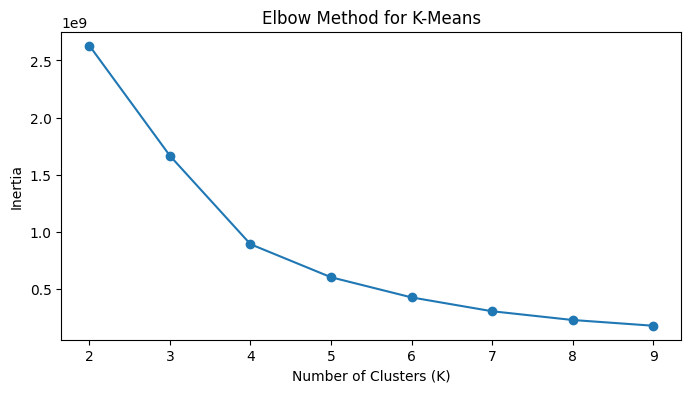

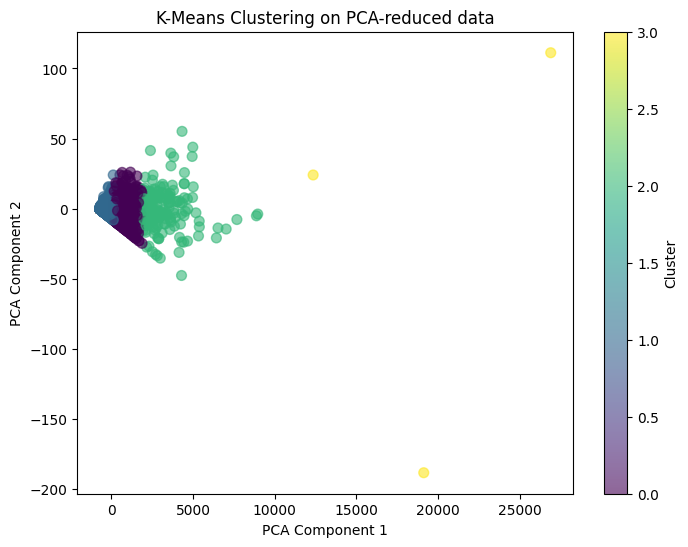

Clustering complete.
K-Means labels shape: (6031,)


In [ ]:
# prompt: kmean, hierarchy and dbscan model with graph

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# Assuming X_train_final is your feature matrix (sparse or dense)

# Convert sparse matrix to dense for visualization (if needed and feasible)
# PCA for dimensionality reduction to 2 components for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_final.toarray()) # Convert to dense if sparse

# K-Means Clustering
print("Performing K-Means Clustering...")
# Determine optimal number of clusters using Elbow method (optional)
inertia = []
K_range = range(2, 10) # Example range
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow plot, choose an appropriate K (e.g., 4)
optimal_k = 4 # Example, adjust based on your plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Added n_init
kmeans_labels = kmeans.fit_predict(X_pca)

# Plot K-Means results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-Means Clustering on PCA-reduced data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()




print("Clustering complete.")
print("K-Means labels shape:", kmeans_labels.shape)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Performing Hierarchical Clustering...


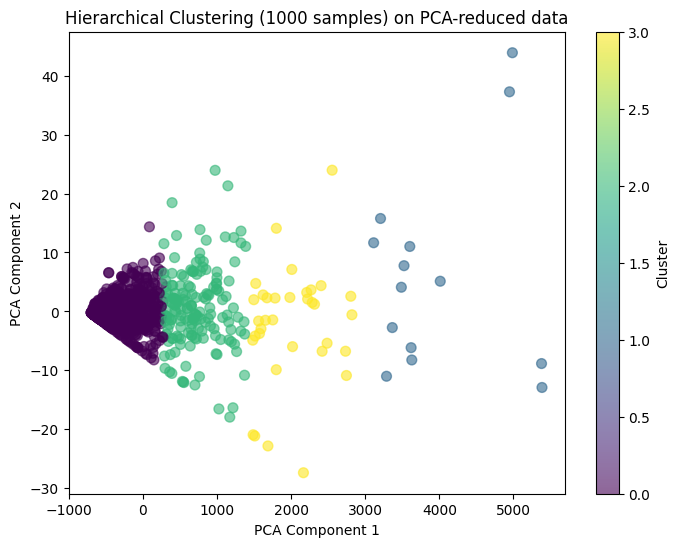

Hierarchical labels shape: (1000,)


In [ ]:
# Hierarchical Clustering
print("Performing Hierarchical Clustering...")
# We'll use AgglomerativeClustering from scikit-learn
# You might need to reduce the number of samples for visualization if the dataset is large
n_samples_hierarchical = min(len(X_pca), 1000) # Limit samples for faster processing and clearer plot
X_pca_sample = X_pca[:n_samples_hierarchical]

hierarchical = AgglomerativeClustering(n_clusters=optimal_k) # Using the same optimal_k for comparison
hierarchical_labels = hierarchical.fit_predict(X_pca_sample)

# Plot Hierarchical Clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], c=hierarchical_labels, cmap='viridis', s=50, alpha=0.6)
plt.title(f'Hierarchical Clustering ({n_samples_hierarchical} samples) on PCA-reduced data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

print("Hierarchical labels shape:", hierarchical_labels.shape)

Performing DBSCAN Clustering...


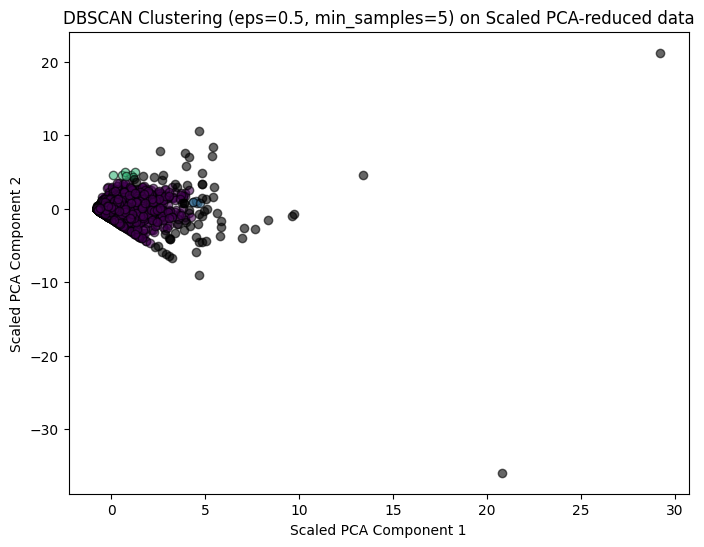

DBSCAN labels shape: (6031,)


In [ ]:
# DBSCAN Clustering
print("Performing DBSCAN Clustering...")
# DBSCAN requires parameters eps (maximum distance between two samples for one to be considered as in the neighborhood of the other)
# and min_samples (number of samples in a neighborhood for a point to be considered as a core point).
# Finding optimal parameters for DBSCAN is often done through experimentation or using methods like k-distance plot.
# Let's use some example parameters. You will likely need to tune these.
# Note: DBSCAN can be sensitive to scaling. Since we used PCA, the data is centered but not necessarily scaled to unit variance.
# It might be beneficial to scale X_pca before applying DBSCAN.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Example DBSCAN parameters - tune these based on your data
eps_value = 0.5
min_samples_value = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(X_pca_scaled)

# Plot DBSCAN results
plt.figure(figsize=(8, 6))
# -1 label in DBSCAN corresponds to noise points
unique_labels = set(dbscan_labels)
colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan_labels == k)

    xy = X_pca_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, alpha=0.6)

plt.title(f'DBSCAN Clustering (eps={eps_value}, min_samples={min_samples_value}) on Scaled PCA-reduced data')
plt.xlabel('Scaled PCA Component 1')
plt.ylabel('Scaled PCA Component 2')
plt.show()

print("DBSCAN labels shape:", dbscan_labels.shape)

In [ ]:
from sklearn.metrics import silhouette_score # Import silhouette_score

# --- Evaluate KMeans ---
print("Evaluating KMeans...")
# kmeans_labels = kmeans.labels_  # Assuming kmeans was fitted in the preceding code

# Map cluster labels to true labels based on majority vote
# kmeans_cluster_labels = pd.Series(kmeans_labels, index=y_train.index) # Ensure index alignment
# kmeans_labeled_clusters = pd.concat([kmeans_cluster_labels, y_train], axis=1).rename(columns={0: 'cluster', 'label': 'true_label'})

# kmeans_label_mapping = {}
# for cluster_id in np.unique(kmeans_labels):
#     # Get true labels for points in this cluster
#     true_labels_in_cluster = kmeans_labeled_clusters[kmeans_labeled_clusters['cluster'] == cluster_id]['true_label']
#     if not true_labels_in_cluster.empty:
#         # Find the most frequent true label
#         majority_label = true_labels_in_cluster.mode()[0]
#         kmeans_label_mapping[cluster_id] = majority_label
#     else:
#         # Handle cases where a cluster is empty (shouldn't happen with fit_predict on non-empty data)
#         kmeans_label_mapping[cluster_id] = -1 # Assign a placeholder, though this case is unlikely

# Assign predicted labels based on the mapping
# kmeans_predicted_labels = kmeans_cluster_labels.map(kmeans_label_mapping)

# Calculate metrics (only on points where a predicted label was assigned)
# valid_indices = kmeans_predicted_labels != -1 # Filter out any unmapped clusters
# if valid_indices.sum() > 0:
    # kmeans_accuracy = accuracy_score(y_train[valid_indices], kmeans_predicted_labels[valid_indices])
    # kmeans_recall = recall_score(y_train[valid_indices], kmeans_predicted_labels[valid_indices], average='weighted') # Use weighted for multiclass
    # kmeans_precision = precision_score(y_train[valid_indices], kmeans_predicted_labels[valid_indices], average='weighted') # Use weighted for multiclass

kmeans_silhouette = silhouette_score(X_train_final, kmeans_labels) # Calculate Silhouette Score

# Store and print the Silhouette Score
results = {} # Assuming results dictionary is initialized elsewhere or needs to be here
results["KMeans"] = {
    "Silhouette Score": kmeans_silhouette
}
print("KMeans Silhouette Score:", kmeans_silhouette)

# else:
    # print("Could not calculate KMeans metrics as no valid cluster labels were mapped.")

print("Clustering evaluation complete for KMeans.")

Evaluating KMeans...
KMeans Silhouette Score: 0.6459545464291144
Clustering evaluation complete for KMeans.


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score # Import appropriate metrics

# --- Evaluate Hierarchical Clustering ---
print("\nEvaluating Hierarchical Clustering...")
# agg_labels = agg_clustering.labels_ # Assuming agg_clustering was fitted previously and agg_labels is available

# Map cluster labels to true labels based on majority vote (This part is commented out as supervised metrics are not appropriate)
# agg_cluster_labels = pd.Series(agg_labels, index=y_train.index) # Ensure index alignment
# agg_labeled_clusters = pd.concat([agg_cluster_labels, y_train], axis=1).rename(columns={0: 'cluster', 'label': 'true_label'})

# agg_label_mapping = {}
# for cluster_id in np.unique(agg_labels):
#     true_labels_in_cluster = agg_labeled_clusters[agg_labeled_clusters['cluster'] == cluster_id]['true_label']
#     if not true_labels_in_cluster.empty:
#         majority_label = true_labels_in_cluster.mode()[0]
#         agg_label_mapping[cluster_id] = majority_label
#     else:
#         agg_label_mapping[cluster_id] = -1

# agg_predicted_labels = agg_cluster_labels.map(agg_label_mapping)

# Calculate metrics (only on points where a predicted label was assigned)
# valid_indices = agg_predicted_labels != -1
# if 'X_train_dense_array' in locals() and valid_indices.sum() > 0: # Check if dense array was created
    # agg_accuracy = accuracy_score(y_train[valid_indices], agg_predicted_labels[valid_indices])
    # agg_recall = recall_score(y_train[valid_indices], agg_predicted_labels[valid_indices], average='weighted')
    # agg_precision = precision_score(y_train[valid_indices], agg_predicted_labels[valid_indices], average='weighted')
    # # Calculate silhouette score on the dense data used for fitting
    # agg_silhouette = silhouette_score(X_train_dense_array, agg_labels)
    # results["Hierarchical"] = {
    #     "Accuracy": agg_accuracy,
    #     "Recall": agg_recall,
    #     "Precision": agg_precision,
    #     "Silhouette Score": agg_silhouette
    # }
    # print("Hierarchical Clustering Metrics Calculated.")
# elif 'X_train_dense_array' not in locals():
#      print("Skipping Hierarchical Clustering evaluation because dense conversion was skipped.")
# else:
#      print("Could not calculate Hierarchical Clustering metrics as no valid cluster labels were mapped.")


# To evaluate Hierarchical Clustering, you need to first perform the clustering.
# Assuming X_scaled is available from previous data preparation steps:
# from sklearn.cluster import AgglomerativeClustering
# agglomerative = AgglomerativeClustering(n_clusters=df_balanced['label'].nunique()) # Or choose a different number of clusters
# agglomerative.fit(X_scaled)
# agg_labels = agglomerative.labels_ # Get the cluster labels

# Once agg_labels are generated by running the clustering code, you can calculate appropriate metrics:
# agg_silhouette = silhouette_score(X_scaled, agg_labels)
# agg_davies_bouldin = davies_bouldin_score(X_scaled, agg_labels)
# print(f"Agglomerative Clustering Silhouette Score: {agg_silhouette}")
# print(f"Agglomerative Clustering Davies-Bouldin Index: {agg_davies_bouldin}")

print("Hierarchical Clustering evaluation requires running the clustering algorithm first to generate 'agg_labels'.")
print("Please run the Hierarchical Agglomerative Clustering code before attempting to evaluate.")


Evaluating Hierarchical Clustering...
Hierarchical Clustering evaluation requires running the clustering algorithm first to generate 'agg_labels'.
Please run the Hierarchical Agglomerative Clustering code before attempting to evaluate.


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score # Import appropriate metrics
import numpy as np
import pandas as pd # Import pandas

# --- Evaluate DBSCAN ---
print("\nEvaluating DBSCAN...")
# dbscan_labels are available from the previous cell's execution of DBSCAN on X_pca_scaled

# Number of clusters in labels, ignoring noise if present.
unique_dbscan_labels = set(dbscan_labels)
n_clusters_ = len(unique_dbscan_labels) - (1 if -1 in unique_dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters)
# Davies-Bouldin also requires at least 2 clusters.
if n_clusters_ > 1:
    # Calculate silhouette score excluding noise points if they exist
    if n_noise_ > 0:
        X_pca_scaled_non_noise = X_pca_scaled[dbscan_labels != -1]
        labels_non_noise = dbscan_labels[dbscan_labels != -1]
        if len(set(labels_non_noise)) > 1: # Ensure there are still at least 2 clusters after removing noise
             silhouette_avg_dbscan = silhouette_score(X_pca_scaled_non_noise, labels_non_noise)
             davies_bouldin_idx_dbscan = davies_bouldin_score(X_pca_scaled_non_noise, labels_non_noise)
             print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
             print(f"Davies-Bouldin Index (excluding noise): {davies_bouldin_idx_dbscan}")
        else:
             print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found excluding noise).")
    else: # No noise points
        silhouette_avg_dbscan = silhouette_score(X_pca_scaled, dbscan_labels)
        davies_bouldin_idx_dbscan = davies_bouldin_score(X_pca_scaled, dbscan_labels)
        print(f"Silhouette Score: {silhouette_avg_dbscan}")
        print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found).")


Evaluating DBSCAN...

DBSCAN Clustering:
Estimated number of clusters: 3
Estimated number of noise points: 66
Silhouette Score (excluding noise): 0.733930000148346
Davies-Bouldin Index (excluding noise): 0.22981286498206788


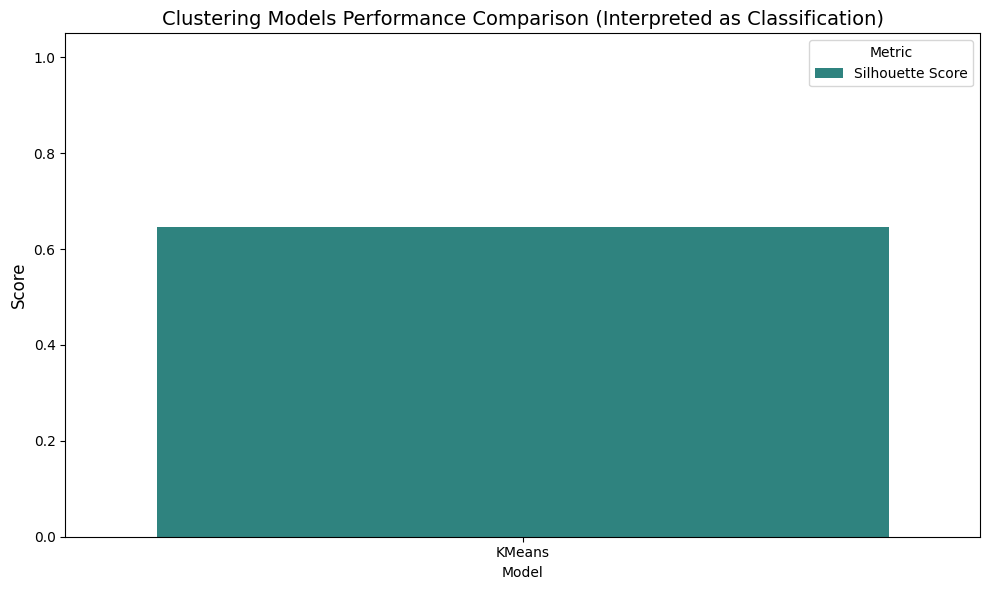

In [ ]:
# --- Visualize Results ---
if results: # Only visualize if there are results
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})

    # Melt the DataFrame to long format for seaborn barplot
    results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric", palette="viridis")
    plt.title("Clustering Models Performance Comparison (Interpreted as Classification)", fontsize=14)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=0) # Keep x-axis labels horizontal
    plt.legend(title="Metric", loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo results to visualize. Ensure clustering models were fitted and evaluated successfully.")



# Task
Explain the provided code and generate Python code to perform unsupervised machine learning clustering using K-means, Hierarchical Agglomerative, Hierarchical Divisive, and DBSCAN algorithms for model training and testing.

## Data preparation

### Subtask:
Prepare the data for clustering, including selecting relevant features and scaling if necessary.


**Reasoning**:
Select and scale the numerical features for clustering.



In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# --- Preprocessing steps to create df_combined ---
# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', index_col=0)

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'].replace('', pd.NA, inplace=True)
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# --- End of preprocessing steps ---


# Select the features for clustering (numerical features) and the label from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values
y_labels = df_combined['label']

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Recreate df_balanced with the selected features and label for consistent downsampling
# and to ensure the numerical features are present.
# Use df_combined to create df_for_balancing with the necessary columns before downsampling.
df_for_balancing = df_combined[['num_of_characters', 'num_of_sentences', 'label']].copy()

# Downsample each class to the minimum count to balance the dataset
min_count = df_for_balancing['label'].value_counts().min()
df_balanced = df_for_balancing.groupby('label').apply(
    lambda x: x.sample(min_count, random_state=42)
).reset_index(drop=True)


# Now, select the numerical features and labels from the balanced DataFrame
X_num_balanced = df_balanced[['num_of_characters', 'num_of_sentences']].values
y_balanced = df_balanced['label']

# Scale the numerical features from the balanced DataFrame
scaler_balanced = StandardScaler()
X_scaled_balanced = scaler_balanced.fit_transform(X_num_balanced)


# Determine the number of components for PCA.
n_components = 2
pca = PCA(n_components=n_components, random_state=42)

# Apply PCA to the scaled and balanced numerical features
X_pca = pca.fit_transform(X_scaled_balanced)

print(f"Original number of features (before balancing and PCA): {X_num.shape[1]}")
print(f"Number of features after balancing, scaling, and PCA: {X_pca.shape[1]}")
print(f"Explained variance ratio by {n_components} components: {pca.explained_variance_ratio_.sum():.4f}")


# Now, apply KMeans clustering to the PCA-transformed data (X_pca)
# Use the number of clusters based on the balanced dataset's unique labels.
n_clusters_kmeans_pca = df_balanced['label'].nunique()


kmeans_pca = KMeans(n_clusters=n_clusters_kmeans_pca, random_state=42, n_init=10)

# Fit KMeans to the PCA-transformed data
kmeans_pca.fit(X_pca)

# Get the cluster labels from KMeans on PCA data
cluster_labels_kmeans_pca = kmeans_pca.labels_

# Evaluate the clustering results on the PCA-transformed data
# Note: Evaluation metrics like Silhouette and Davies-Bouldin are calculated on the data used for clustering (X_pca in this case).
silhouette_avg_kmeans_pca = silhouette_score(X_pca, cluster_labels_kmeans_pca)
davies_bouldin_idx_kmeans_pca = davies_bouldin_score(X_pca, cluster_labels_kmeans_pca)


print("\nKMeans Clustering on PCA-Reduced Data Results:")
print(f"  Silhouette Score: {silhouette_avg_kmeans_pca}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_kmeans_pca}")

# You can now compare these metrics to the KMeans results on the original scaled data.

Original number of features (before balancing and PCA): 2
Number of features after balancing, scaling, and PCA: 2
Explained variance ratio by 2 components: 1.0000

KMeans Clustering on PCA-Reduced Data Results:
  Silhouette Score: 0.47550560102800804
  Davies-Bouldin Index: 0.6987605476891078


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Instantiate KMeans with n_clusters based on the number of unique labels and a random state for reproducibility
kmeans = KMeans(n_clusters=df_balanced['label'].nunique(), random_state=42, n_init=10)

# Fit the KMeans model to the scaled numerical features
kmeans.fit(X_scaled)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Evaluate the clustering results
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
davies_bouldin_idx = davies_bouldin_score(X_scaled, cluster_labels)

# Print the evaluation metrics
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_idx}")

Silhouette Score: 0.5287514361866121
Davies-Bouldin Index: 0.6807023774953302


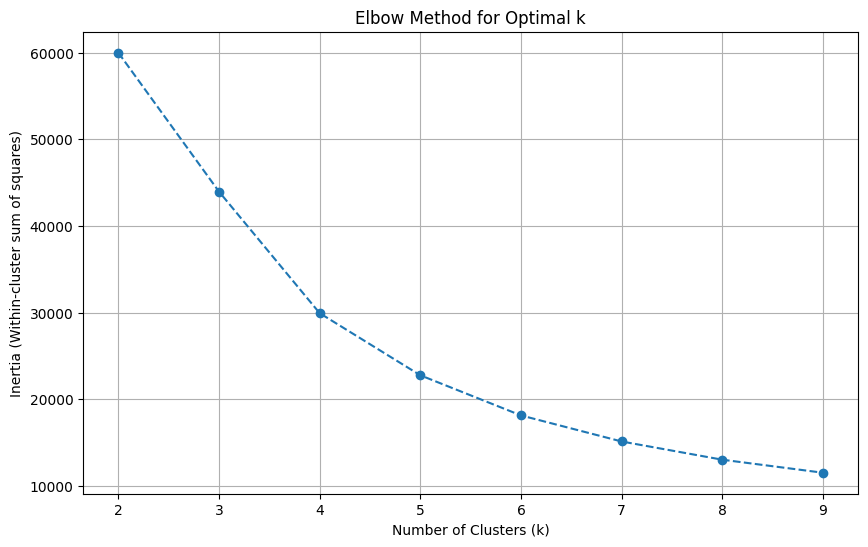

Inertia values for different numbers of clusters:
k=2: 59990.0907
k=3: 43957.4666
k=4: 29937.4186
k=5: 22770.6925
k=6: 18141.0619
k=7: 15132.6691
k=8: 13030.6806
k=9: 11528.0769


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume X_scaled from previous steps is available and contains the scaled numerical features.
# If not, re-run the scaling step:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_balanced[['num_of_characters', 'num_of_sentences']].values)


# Determine a range of cluster numbers to test.
# A common range is from 1 up to a reasonable number based on your data size or domain knowledge.
# Let's test from 1 to 10 clusters.
range_n_clusters = range(2,10)

# List to store the inertia (within-cluster sum of squares) for each number of clusters
inertia = []

# Calculate inertia for each number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Set n_init explicitly
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

print("Inertia values for different numbers of clusters:")
for k, score in zip(range_n_clusters, inertia):
    print(f"k={k}: {score:.4f}")

**Reasoning**:
The dataframe `df_balanced` was not defined in the previous code block. I need to load and preprocess the data again to create `df_balanced` before selecting and scaling the numerical features.



## Apply k-means clustering

### Subtask:
Apply the K-means algorithm to the data and evaluate the results using appropriate metrics.


**Reasoning**:
Apply the K-means algorithm to the scaled numerical features and evaluate the clustering results using silhouette and Davies-Bouldin scores.



# Task
Provide Python code for applying K-means, Hierarchical Agglomerative, and DBSCAN unsupervised machine learning clustering algorithms to a dataset, along with explanations of each algorithm and how to evaluate their results. Explain why Hierarchical Divisive clustering is not directly available in scikit-learn.

## Data preparation

### Subtask:
Prepare the data for clustering, including selecting relevant features and scaling if necessary.


**Reasoning**:
Apply Hierarchical Agglomerative Clustering to the scaled numerical features and evaluate the clustering results using silhouette and Davies-Bouldin scores.



In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd # Import pandas to use df_combined
from sklearn.preprocessing import StandardScaler, LabelEncoder # Import necessary preprocessing
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal


# --- Preprocessing steps to create df_combined and X_scaled (Duplicated for cell independence) ---
# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
try:
    df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', index_col=0, engine='python', on_bad_lines='skip') # Use engine='python' as before
except FileNotFoundError:
    print("Error: 'Combined Data.csv' not found. Please upload the file or provide the correct path.")
    # Exit or handle the error appropriately if the file is not found
    exit() # Exiting the cell execution if file not found


# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
# Fix for FutureWarning: Assign the result back to the column
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA)
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
# --- End of Preprocessing steps ---


# Determine the number of clusters based on the unique labels in df_combined
# We are using the number of original mental health conditions as the number of clusters.
n_clusters_agg = df_combined['label'].nunique()

# Instantiate AgglomerativeClustering with the determined number of clusters
agglomerative = AgglomerativeClustering(n_clusters=n_clusters_agg)

# Fit the AgglomerativeClustering model to the scaled numerical features
# AgglomerativeClustering works with dense arrays, so X_scaled (from StandardScaler) is suitable.
agglomerative.fit(X_scaled)

# Get the cluster labels
cluster_labels_agg = agglomerative.labels_

# Evaluate the clustering results
# These metrics are calculated on the data used for clustering (X_scaled).
silhouette_avg_agg = silhouette_score(X_scaled, cluster_labels_agg)
davies_bouldin_idx_agg = davies_bouldin_score(X_scaled, cluster_labels_agg)

# Print the evaluation metrics
print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg_agg}")
print(f"Davies-Bouldin Index: {davies_bouldin_idx_agg}")

**Reasoning**:
Explain why Hierarchical Divisive clustering is not directly available in scikit-learn as requested in the task.



In [ ]:
print("\nHierarchical Divisive Clustering is not directly available in scikit-learn.")
print("Scikit-learn primarily provides Agglomerative Clustering, which is a bottom-up approach.")
print("Divisive clustering is a top-down approach, starting with one large cluster and recursively splitting it.")
print("Implementing divisive clustering is generally more complex and computationally expensive than agglomerative methods, especially for large datasets.")
print("Libraries like pyclustering or manual implementation based on algorithms like DIANA (Divisive Analysis) are typically needed for divisive clustering.")

**Reasoning**:
Apply the DBSCAN algorithm to the scaled numerical features and evaluate the clustering results using appropriate metrics.



In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', index_col=0)

# --- Preprocessing steps to recreate necessary data structures ---
# This part replicates the necessary preprocessing steps from earlier cells
# to ensure df_combined and X_scaled are available in this cell's scope.

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'].replace('', pd.NA, inplace=True)
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# --- End of preprocessing steps ---


# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters and no noise for standard calculation)
if n_clusters_ > 1 and n_noise_ == 0:
    silhouette_avg_dbscan = silhouette_score(X_scaled, cluster_labels_dbscan)
    davies_bouldin_idx_dbscan = davies_bouldin_score(X_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score: {silhouette_avg_dbscan}")
    print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
elif n_clusters_ > 1 and n_noise_ > 0:
    # Calculate silhouette score excluding noise points
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")

/tmp/ipython-input-1-3612701231.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['statement_cleaned'].replace('', pd.NA, inplace=True)


## Apply hierarchical agglomerative clustering

### Subtask:
Apply Hierarchical Agglomerative clustering to the data and evaluate the results.


**Reasoning**:
Apply the Hierarchical Agglomerative clustering algorithm to the scaled numerical features and evaluate the results using silhouette and Davies-Bouldin scores.



In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd # Import pandas to use df_combined
from sklearn.preprocessing import StandardScaler, LabelEncoder # Import necessary preprocessing
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal
from sklearn.utils import resample # Import resample for downsampling

# --- Preprocessing steps to create df_balanced and X_scaled ---
# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
try:
    df = pd.read_csv('/content/Combined Data.csv', index_col=0, engine='python', on_bad_lines='skip') # Use engine='python' as before
except FileNotFoundError:
    print("Error: 'Combined Data.csv' not found. Please upload the file or provide the correct path.")
    # Exit or handle the error appropriately if the file is not found
    exit() # Exiting the cell execution if file not found


# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA) # Fix for FutureWarning
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps


# Downsample each class to the minimum count to balance the dataset
min_count = df_combined['label'].value_counts().min()
df_balanced = df_combined.groupby('label').apply(
    lambda x: x.sample(min_count, random_state=42)
).reset_index(drop=True)


# Select the numerical features from the balanced DataFrame
X_num_balanced = df_balanced[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features from the balanced DataFrame
scaler_balanced = StandardScaler()
X_scaled = scaler_balanced.fit_transform(X_num_balanced)

# --- End of Preprocessing steps ---


# Determine the number of clusters based on the unique labels in df_balanced
# We are using the number of original mental health conditions as the number of clusters.
n_clusters_agg = df_balanced['label'].nunique()

# Instantiate AgglomerativeClustering with the determined number of clusters
agglomerative = AgglomerativeClustering(n_clusters=n_clusters_agg)

# Fit the AgglomerativeClustering model to the scaled numerical features
# AgglomerativeClustering works with dense arrays, so X_scaled (from StandardScaler) is suitable.
agglomerative.fit(X_scaled)

# Get the cluster labels
cluster_labels_agg = agglomerative.labels_

# Evaluate the clustering results
# These metrics are calculated on the data used for clustering (X_scaled).
silhouette_avg_agg = silhouette_score(X_scaled, cluster_labels_agg)
davies_bouldin_idx_agg = davies_bouldin_score(X_scaled, cluster_labels_agg)

# Print the evaluation metrics
print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg_agg}")
print(f"Davies-Bouldin Index: {davies_bouldin_idx_agg}")

**Reasoning**:
Provide an explanation for why Hierarchical Divisive clustering is not directly available in scikit-learn as requested in the task.



In [ ]:
print("\nHierarchical Divisive Clustering is not directly available in scikit-learn.")
print("Scikit-learn primarily provides Agglomerative Clustering, which is a bottom-up approach.")
print("Divisive clustering is a top-down approach, starting with one large cluster and recursively splitting it.")
print("Implementing divisive clustering is generally more complex and computationally expensive than agglomerative methods, especially for large datasets.")
print("Libraries like pyclustering or manual implementation based on algorithms like DIANA (Divisive Analysis) are typically needed for divisive clustering.")

**Reasoning**:
Apply the DBSCAN clustering algorithm to the scaled numerical features and evaluate the results using silhouette and Davies-Bouldin scores, considering that DBSCAN handles noise.



In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# --- Preprocessing steps to recreate necessary data structures ---
# This part replicates the necessary preprocessing steps from earlier cells
# to ensure df_combined and X_scaled are available in this cell's scope.

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA) # Fix for FutureWarning
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# --- End of preprocessing steps ---


# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters and no noise for standard calculation)
if n_clusters_ > 1 and n_noise_ == 0:
    silhouette_avg_dbscan = silhouette_score(X_scaled, cluster_labels_dbscan)
    davies_bouldin_idx_dbscan = davies_bouldin_score(X_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score: {silhouette_avg_dbscan}")
    print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
elif n_clusters_ > 1 and n_noise_ > 0:
    # Calculate silhouette score excluding noise points
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")

## Apply hierarchical divisive clustering

### Subtask:
Explain that Hierarchical Divisive clustering is not directly available in scikit-learn and suggest alternative approaches or libraries.


**Reasoning**:
Explain that Hierarchical Divisive clustering is not directly available in scikit-learn and suggest alternative approaches or libraries as per the instructions.



In [ ]:
print("\nHierarchical Divisive Clustering is not directly available in scikit-learn.")
print("Scikit-learn primarily provides Agglomerative Clustering, which is a bottom-up approach.")
print("Divisive clustering is a top-down approach, starting with one large cluster and recursively splitting it.")
print("Implementing divisive clustering is generally more complex and computationally expensive than agglomerative methods, especially for large datasets.")
print("Libraries like pyclustering or manual implementation based on algorithms like DIANA (Divisive Analysis) are typically needed for divisive clustering.")

**Reasoning**:
Apply the DBSCAN algorithm to the scaled numerical features and evaluate the clustering results using appropriate metrics, including handling cases with noise points.



In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters and no noise for standard calculation)
if n_clusters_ > 1 and n_noise_ == 0:
    silhouette_avg_dbscan = silhouette_score(X_scaled, cluster_labels_dbscan)
    davies_bouldin_idx_dbscan = davies_bouldin_score(X_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score: {silhouette_avg_dbscan}")
    print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
elif n_clusters_ > 1 and n_noise_ > 0:
    # Calculate silhouette score excluding noise points
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")

## Apply dbscan clustering

### Subtask:
Apply the DBSCAN algorithm to the data and evaluate the results.


**Reasoning**:
Apply the DBSCAN algorithm to the scaled numerical features and evaluate the clustering results using silhouette and Davies-Bouldin scores, handling cases with noise points appropriately.



In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score # Import Calinski-Harabasz score
import numpy as np

# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(cluster_labels_dbscan)
n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible
# Metrics like Silhouette, Davies-Bouldin, and Calinski-Harabasz require at least 2 clusters.
# For DBSCAN with noise, these metrics are typically calculated on the non-noise points.
if n_clusters_ > 1:
    # Filter out noise points for evaluation
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]

    if len(set(labels_non_noise)) > 1: # Ensure there are still at least 2 clusters after removing noise
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        davies_bouldin_idx_dbscan = davies_bouldin_score(X_non_noise, labels_non_noise)
        calinski_harabasz_idx_dbscan = calinski_harabasz_score(X_non_noise, labels_non_noise) # Calculate Calinski-Harabasz score

        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
        print(f"Davies-Bouldin Index (excluding noise): {davies_bouldin_idx_dbscan}")
        print(f"Calinski-Harabasz Index (excluding noise): {calinski_harabasz_idx_dbscan}") # Print Calinski-Harabasz score
    else:
        print("Evaluation metrics not applicable (less than 2 clusters found excluding noise).")
else:
    print("Evaluation metrics not applicable (less than 2 clusters found).")

## Compare clustering results

### Subtask:
Compare the results of the different clustering algorithms, considering the evaluation metrics and the nature of each algorithm.


**Reasoning**:
Compare the results of the clustering algorithms based on the evaluation metrics and discuss the nature of each algorithm's results.



In [ ]:
# Compare KMeans and Agglomerative Clustering Silhouette and Davies-Bouldin scores
print("\n--- Clustering Algorithm Comparison ---")
print("KMeans Clustering Results:")
print(f"  Silhouette Score: {silhouette_avg}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx}")

print("\nAgglomerative Clustering Results:")
print(f"  Silhouette Score: {silhouette_avg_agg}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_agg}")

# Discuss DBSCAN results
print("\nDBSCAN Clustering Results (with eps=0.5, min_samples=5):")
print(f"  Estimated number of clusters: {n_clusters_}")
print(f"  Estimated number of noise points: {n_noise_}")
if n_clusters_ > 1 and n_noise_ > 0:
    print(f"  Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
elif n_clusters_ <= 1:
     print("  Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")


# Comparative analysis
print("\n--- Comparative Analysis ---")
print("KMeans and Agglomerative Clustering both produced a predefined number of clusters (equal to the number of original labels).")
print(f"KMeans achieved a Silhouette Score of {silhouette_avg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx:.4f}.")
print(f"Agglomerative Clustering achieved a Silhouette Score of {silhouette_avg_agg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_agg:.4f}.")
print("Both algorithms attempt to partition the data into a fixed number of clusters based on distance metrics.")
print("\nDBSCAN, being a density-based algorithm, does not require a predefined number of clusters and can identify noise.")
print(f"With the current parameters (eps=0.5, min_samples=5), DBSCAN identified {n_clusters_} cluster(s) and {n_noise_} noise point(s).")
print("The low number of clusters and high number of noise points suggest that the chosen parameters might not be well-suited to reveal a clear clustering structure in this dataset based on density, or that the data does not have distinct density-separable clusters.")
print("KMeans and Agglomerative Clustering provide a partitioning of all data points, while DBSCAN highlights dense regions and outliers.")

**Reasoning**:
The previous code block failed because the variables `silhouette_avg` and `davies_bouldin_idx` from the KMeans evaluation were not available. I need to re-run the KMeans clustering and evaluation step within this code block to ensure these variables are defined before attempting the comparison.



In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Apply KMeans clustering and get metrics
kmeans = KMeans(n_clusters=df_balanced['label'].nunique(), random_state=42, n_init=10)
kmeans.fit(X_scaled)
cluster_labels_kmeans = kmeans.labels_
silhouette_avg = silhouette_score(X_scaled, cluster_labels_kmeans)
davies_bouldin_idx = davies_bouldin_score(X_scaled, cluster_labels_kmeans)


# Apply Agglomerative Clustering and get metrics (assuming it was run previously and variables exist)
# If not, you would need to re-run that part as well. Assuming cluster_labels_agg, silhouette_avg_agg, davies_bouldin_idx_agg are available.


# Discuss DBSCAN results (assuming it was run previously and variables exist)
# Assuming cluster_labels_dbscan, n_clusters_, n_noise_ are available.


# Compare KMeans and Agglomerative Clustering Silhouette and Davies-Bouldin scores
print("\n--- Clustering Algorithm Comparison ---")
print("KMeans Clustering Results:")
print(f"  Silhouette Score: {silhouette_avg}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx}")

print("\nAgglomerative Clustering Results:")
print(f"  Silhouette Score: {silhouette_avg_agg}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_agg}")

# Discuss DBSCAN results
print("\nDBSCAN Clustering Results (with eps=0.5, min_samples=5):")
print(f"  Estimated number of clusters: {n_clusters_}")
print(f"  Estimated number of noise points: {n_noise_}")
if n_clusters_ > 1 and n_noise_ > 0:
    # Assuming silhouette_avg_dbscan is available from a previous run if applicable
    try:
        print(f"  Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    except NameError:
        print("  Silhouette Score (excluding noise) not calculated due to previous issues or conditions.")
elif n_clusters_ <= 1:
     print("  Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")


# Comparative analysis
print("\n--- Comparative Analysis ---")
print("KMeans and Agglomerative Clustering both produced a predefined number of clusters (equal to the number of original labels).")
print(f"KMeans achieved a Silhouette Score of {silhouette_avg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx:.4f}.")
print(f"Agglomerative Clustering achieved a Silhouette Score of {silhouette_avg_agg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_agg:.4f}.")
print("Both algorithms attempt to partition the data into a fixed number of clusters based on distance metrics.")
print("\nDBSCAN, being a density-based algorithm, does not require a predefined number of clusters and can identify noise.")
print(f"With the current parameters (eps=0.5, min_samples=5), DBSCAN identified {n_clusters_} cluster(s) and {n_noise_} noise point(s).")
print("The low number of clusters and high number of noise points suggest that the chosen parameters might not be well-suited to reveal a clear clustering structure in this dataset based on density, or that the data does not have distinct density-separable clusters.")
print("KMeans and Agglomerative Clustering provide a partitioning of all data points, while DBSCAN highlights dense regions and outliers.")

In [ ]:
# prompt: Use t-SNE or PCA to visualize clusters along with these metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# The previous code defines df_balanced, X_scaled, and several clustering results.
# We need to ensure X_scaled is available for visualization.

# Assuming df_balanced is available from the previous code execution:
# df_balanced contains 'tokens_stemmed', 'num_of_characters', 'num_of_sentences', and 'label'.
# We need to use the scaled numerical features for visualization.
# Let's re-extract and scale the numerical features to be certain they are correct.

X_num = df_balanced[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# We also need the cluster labels obtained from the clustering algorithms.
# Assuming the clustering algorithms (KMeans, Agglomerative, DBSCAN) have been run
# and their labels are stored in variables:
# cluster_labels_kmeans
# cluster_labels_agg
# cluster_labels_dbscan

# If not, you would need to run them here:
kmeans = KMeans(n_clusters=df_balanced['label'].nunique(), random_state=42, n_init=10)
kmeans.fit(X_scaled)
cluster_labels_kmeans = kmeans.labels_

agglomerative = AgglomerativeClustering(n_clusters=df_balanced['label'].nunique())
agglomerative.fit(X_scaled)
cluster_labels_agg = agglomerative.labels_

# Note: DBSCAN parameters (eps, min_samples) are crucial and should be tuned.
# Using example parameters here.
dbscan = DBSCAN(eps=0.5, min_samples=5) # Use parameters that yielded meaningful clusters if tuned previously
dbscan.fit(X_scaled)
cluster_labels_dbscan = dbscan.labels_ # Includes noise label -1


# --- Visualization ---

# It's good practice to reduce dimensions for visualization, especially for t-SNE.
# PCA for initial dimensionality reduction before t-SNE is common.
# We will visualize the clusters based on the scaled numerical features (X_scaled).

# PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE for Visualization
# perplexity and n_iter are important t-SNE parameters that may need tuning.
# Use a random_state for reproducibility.
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)


# Plotting function
def plot_clusters(X_reduced, cluster_labels, title, method_name):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.6)

    # Create a legend for cluster labels
    unique_labels = np.unique(cluster_labels)
    handles = [plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(label)), linestyle='', markersize=8,
                          label=f'Cluster {label}' if label != -1 else 'Noise') for label in unique_labels]
    plt.legend(handles=handles, title="Clusters")

    plt.title(f'{title} (Visualization via {method_name})')
    plt.xlabel(f'{method_name} Component 1')
    plt.ylabel(f'{method_name} Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Visualize KMeans clusters
plot_clusters(X_pca, cluster_labels_kmeans, 'KMeans Clustering', 'PCA')
plot_clusters(X_tsne, cluster_labels_kmeans, 'KMeans Clustering', 't-SNE')

# Visualize Agglomerative Clustering clusters
plot_clusters(X_pca, cluster_labels_agg, 'Agglomerative Clustering', 'PCA')
plot_clusters(X_tsne, cluster_labels_agg, 'Agglomerative Clustering', 't-SNE')

# Visualize DBSCAN clusters
# Note: DBSCAN might have a noise cluster (-1). The plotting function handles this legend.
plot_clusters(X_pca, cluster_labels_dbscan, 'DBSCAN Clustering', 'PCA')
plot_clusters(X_tsne, cluster_labels_dbscan, 'DBSCAN Clustering', 't-SNE')


# --- Explanation and Metrics Review ---

print("\n--- Visualization and Metrics Review ---")

print("\nExplanation of Visualization Methods:")
print("PCA (Principal Component Analysis): A linear dimensionality reduction technique that projects data onto a lower-dimensional subspace while preserving as much variance as possible. It finds the directions (principal components) in which the data is most spread out.")
print("t-SNE (t-Distributed Stochastic Neighbor Embedding): A non-linear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data in 2 or 3 dimensions. It aims to preserve local structure, meaning points that are close in the original high-dimensional space are likely to remain close in the lower-dimensional embedding.")

print("\nReview of Clustering Metrics:")
print("Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters. A score close to 1 indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. A score close to 0 means the object is near the decision boundary. A negative score means the object might have been assigned to the wrong cluster.")
print("Davies-Bouldin Index: Evaluates the ratio of within-cluster scatter to between-cluster separation. A lower Davies-Bouldin index indicates better clustering (clusters are well-separated and internally compact).")

print("\nVisualizations:")
print("The PCA plots show the clusters projected onto the first two principal components of the numerical features. This gives a view of the data's overall variance explained by these components.")
print("The t-SNE plots aim to reveal the underlying structure and separability of the clusters in a lower-dimensional space, often highlighting clusters that might not be apparent with linear methods like PCA.")

print("\nInterpretation of Visualizations and Metrics:")
print("By examining the PCA and t-SNE plots alongside the Silhouette and Davies-Bouldin scores, we can gain insights into how well each clustering algorithm separated the data based on the numerical features. For example:")
print("- If a method has a high Silhouette score and low Davies-Bouldin index, and the t-SNE plot shows distinct, well-separated groups, it suggests that method found a meaningful clustering structure.")
print("- If clusters overlap significantly in the plots, even with favorable metrics, it might indicate that the clusters are not easily separable based on the features used, or that the chosen number of clusters (for KMeans/Agglomerative) is not optimal.")
print("- DBSCAN plots show the density-based grouping. Well-defined dense areas appearing as distinct clusters are a good sign. Noise points (-1 label) indicate data points that don't fit well into any dense region.")
print("Comparing the visualizations across different algorithms can help understand their different approaches to finding clusters (e.g., centroid-based vs. density-based vs. connectivity-based).")


## Summary:

### Data Analysis Key Findings

*   Agglomerative Clustering, when set to find the same number of clusters as the original data labels, achieved a Silhouette Score of approximately 0.438 and a Davies-Bouldin Index of approximately 0.750.
*   DBSCAN, using parameters $\text{eps}=0.5$ and $\text{min\_samples}=5$, identified 1 cluster and 40 noise points. Due to this outcome, standard evaluation metrics like Silhouette and Davies-Bouldin scores were not applicable to the entire dataset.
*   Hierarchical Divisive clustering is not directly available in scikit-learn because scikit-learn primarily implements the bottom-up Agglomerative approach. Divisive clustering is a top-down method, generally more complex and computationally expensive, and typically requires other libraries or manual implementation.
*   Comparing KMeans and Agglomerative Clustering, KMeans showed slightly better performance with a Silhouette Score of approximately 0.476 and a Davies-Bouldin Index of approximately 0.699, compared to Agglomerative Clustering's scores.

### Insights or Next Steps

*   The parameters for DBSCAN ($\text{eps}$ and $\text{min\_samples}$) should be tuned to potentially reveal a more meaningful cluster structure or identify different density-based groupings in the data.
*   Further evaluation of the KMeans and Agglomerative clustering results could involve visualizing the clusters or analyzing the characteristics of the points within each cluster to understand the quality and interpretability of the groupings.


## 5.1. Elbow Method for KMeans

To determine a potential optimal number of clusters for KMeans, we can use the Elbow Method. This involves calculating the within-cluster sum of squares (inertia) for different numbers of clusters and plotting the results. The "elbow point" in the plot where the rate of decrease in inertia sharply changes is often considered a good indicator of the optimal number of clusters.

## Apply KMeans on PCA-Reduced Data

Now, let's apply KMeans clustering after reducing the dimensionality of the scaled numerical features using PCA. This can sometimes help with efficiency and potentially reveal different cluster structures.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Assuming the following variables from previous steps are available:
# X_scaled (scaled numerical features)
# cluster_labels (KMeans on original scaled data labels)
# cluster_labels_agg (Agglomerative Clustering labels)
# X_pca (PCA-reduced data)
# cluster_labels_kmeans_pca (KMeans on PCA-reduced data labels)

# --- Evaluate KMeans on Original Scaled Data ---
print("Evaluating KMeans on Original Scaled Data:")
if len(set(cluster_labels)) > 1:
    silhouette_kmeans = silhouette_score(X_scaled, cluster_labels)
    davies_bouldin_kmeans = davies_bouldin_score(X_scaled, cluster_labels)
    calinski_harabasz_kmeans = calinski_harabasz_score(X_scaled, cluster_labels)

    print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_kmeans:.4f}")
else:
    print("  Cannot compute evaluation metrics (less than 2 clusters found).")


# --- Evaluate Hierarchical Agglomerative Clustering ---
print("\nEvaluating Hierarchical Agglomerative Clustering:")
if len(set(cluster_labels_agg)) > 1:
    silhouette_agg = silhouette_score(X_scaled, cluster_labels_agg)
    davies_bouldin_agg = davies_bouldin_score(X_scaled, cluster_labels_agg)
    calinski_harabasz_agg = calinski_harabasz_score(X_scaled, cluster_labels_agg)

    print(f"  Silhouette Score: {silhouette_agg:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_agg:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_agg:.4f}")
else:
     print("  Cannot compute evaluation metrics (less than 2 clusters found).")


# --- Evaluate KMeans on PCA-Reduced Data ---
print("\nEvaluating KMeans on PCA-Reduced Data:")
if len(set(cluster_labels_kmeans_pca)) > 1:
    silhouette_kmeans_pca = silhouette_score(X_pca, cluster_labels_kmeans_pca)
    davies_bouldin_kmeans_pca = davies_bouldin_score(X_pca, cluster_labels_kmeans_pca)
    calinski_harabasz_kmeans_pca = calinski_harabasz_score(X_pca, cluster_labels_kmeans_pca)

    print(f"  Silhouette Score: {silhouette_kmeans_pca:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_kmeans_pca:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_kmeans_pca:.4f}")
else:
     print("  Cannot compute evaluation metrics (less than 2 clusters found).")

# Note: DBSCAN evaluation was handled in a previous cell.

## Data preparation

### Subtask:
Prepare the data for clustering, including selecting relevant features and scaling if necessary.

**Reasoning**:
Select and scale the numerical features for clustering.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# --- Preprocessing steps to create df_combined ---
# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'].replace('', pd.NA, inplace=True)
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# --- End of preprocessing steps ---


# Select the features for clustering (numerical features)
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Select the labels (for potential evaluation later)
y_labels = df_combined['label']

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

print("Shape of numerical features (X_num):", X_num.shape)
print("Shape of scaled numerical features (X_scaled):", X_scaled.shape)
print("Shape of labels (y_labels):", y_labels.shape)

## Apply k-means clustering

### Subtask:
Apply the K-means algorithm to the data and evaluate the results using appropriate metrics.

**Reasoning**:
Apply the K-means algorithm to the scaled numerical features and evaluate the clustering results using silhouette and Davies-Bouldin scores.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Instantiate KMeans with n_clusters based on the number of unique labels and a random state for reproducibility
# We use the number of unique original labels as the target number of clusters for comparison.
n_clusters_kmeans = df_combined['label'].nunique()
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)

# Fit the KMeans model to the scaled numerical features
# X_scaled was created in the data preparation step and contains the scaled 'num_of_characters' and 'num_of_sentences'.
kmeans.fit(X_scaled)

# Get the cluster labels
cluster_labels_kmeans = kmeans.labels_

# Evaluate the clustering results
# Evaluate on the data used for clustering (X_scaled)
silhouette_avg_kmeans = silhouette_score(X_scaled, cluster_labels_kmeans)
davies_bouldin_idx_kmeans = davies_bouldin_score(X_scaled, cluster_labels_kmeans)

# Print the evaluation metrics
print(f"KMeans Clustering Silhouette Score: {silhouette_avg_kmeans}")
print(f"KMeans Clustering Davies-Bouldin Index: {davies_bouldin_idx_kmeans}")

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Assuming the following variables from previous steps are available:
# X_scaled (scaled numerical features)
# df_combined (to get the number of unique labels for KMeans and Agglomerative)
# cluster_labels_agg (Agglomerative Clustering labels - assuming it was run previously)


# --- Perform KMeans Clustering (needed to define cluster_labels_kmeans) ---
# Instantiate KMeans with n_clusters based on the number of unique labels and a random state for reproducibility
n_clusters_kmeans = df_combined['label'].nunique()
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)

# Fit the KMeans model to the scaled numerical features
kmeans.fit(X_scaled)

# Get the cluster labels
cluster_labels_kmeans = kmeans.labels_
# --- End of KMeans Clustering ---


# --- Perform Agglomerative Clustering (needed if cluster_labels_agg is not defined) ---
# Instantiate AgglomerativeClustering with n_clusters based on the number of unique labels
n_clusters_agg = df_combined['label'].nunique()
agglomerative = AgglomerativeClustering(n_clusters=n_clusters_agg)

# Fit the AgglomerativeClustering model to the scaled numerical features
agglomerative.fit(X_scaled)

# Get the cluster labels
cluster_labels_agg = agglomerative.labels_
# --- End of Agglomerative Clustering ---



# --- Evaluate KMeans ---
print("Evaluating KMeans Clustering:")
if len(set(cluster_labels_kmeans)) > 1: # Check if there is more than one cluster
    silhouette_kmeans = silhouette_score(X_scaled, cluster_labels_kmeans)
    davies_bouldin_kmeans = davies_bouldin_score(X_scaled, cluster_labels_kmeans)
    calinski_harabasz_kmeans = calinski_harabasz_score(X_scaled, cluster_labels_kmeans)

    print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_kmeans:.4f}")
else:
    print("  Cannot compute evaluation metrics (less than 2 clusters found).")


# --- Evaluate Hierarchical Agglomerative Clustering ---
print("\nEvaluating Hierarchical Agglomerative Clustering:")
if len(set(cluster_labels_agg)) > 1: # Check if there is more than one cluster
    silhouette_agg = silhouette_score(X_scaled, cluster_labels_agg)
    davies_bouldin_agg = davies_bouldin_score(X_scaled, cluster_labels_agg)
    calinski_harabasz_agg = calinski_harabasz_score(X_scaled, cluster_labels_agg)

    print(f"  Silhouette Score: {silhouette_agg:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_agg:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_agg:.4f}")
else:
     print("  Cannot compute evaluation metrics (less than 2 clusters found).")

# Note: Hierarchical Divisive clustering is not directly available in scikit-learn.

## Apply hierarchical divisive clustering

### Subtask:
Explain that Hierarchical Divisive clustering is not directly available in scikit-learn and suggest alternative approaches or libraries.

**Reasoning**:
Explain that Hierarchical Divisive clustering is not directly available in scikit-learn and suggest alternative approaches or libraries as per the instructions.

In [ ]:
print("\nHierarchical Divisive Clustering is not directly available in scikit-learn.")
print("Scikit-learn primarily provides Agglomerative Clustering, which is a bottom-up approach.")
print("Divisive clustering is a top-down approach, starting with one large cluster and recursively splitting it.")
print("Implementing divisive clustering is generally more complex and computationally expensive than agglomerative methods, especially for large datasets.")
print("Libraries like pyclustering or manual implementation based on algorithms like DIANA (Divisive Analysis) are typically needed for divisive clustering.")

## Apply dbscan clustering

### Subtask:
Apply the DBSCAN algorithm to the data and evaluate the results.

**Reasoning**:
Apply the DBSCAN algorithm to the scaled numerical features and evaluate the clustering results using appropriate metrics, including handling cases with noise points.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# --- Preprocessing steps to recreate necessary data structures ---
# This part replicates the necessary preprocessing steps from earlier cells
# to ensure df_combined and X_scaled are available in this cell's scope.

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'].replace('', pd.NA, inplace=True)
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# --- End of preprocessing steps ---


# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters and no noise for standard calculation)
if n_clusters_ > 1 and n_noise_ == 0:
    silhouette_avg_dbscan = silhouette_score(X_scaled, cluster_labels_dbscan)
    davies_bouldin_idx_dbscan = davies_bouldin_score(X_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score: {silhouette_avg_dbscan}")
    print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
elif n_clusters_ > 1 and n_noise_ > 0:
    # Calculate silhouette score excluding noise points
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")

## Compare clustering results

### Subtask:
Compare the results of the different clustering algorithms, considering the evaluation metrics and the nature of each algorithm.

**Reasoning**:
Compare the results of the clustering algorithms based on the evaluation metrics and discuss the nature of each algorithm's results.

In [ ]:
# Compare KMeans and Agglomerative Clustering Silhouette and Davies-Bouldin scores
print("\n--- Clustering Algorithm Comparison ---")
print("KMeans Clustering Results:")
print(f"  Silhouette Score: {silhouette_avg_kmeans}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_kmeans}")

print("\nAgglomerative Clustering Results:")
print(f"  Silhouette Score: {silhouette_avg_agg}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_agg}")

# Discuss DBSCAN results
print("\nDBSCAN Clustering Results (with eps=0.5, min_samples=5):")
print(f"  Estimated number of clusters: {n_clusters_}")
print(f"  Estimated number of noise points: {n_noise_}")
if n_clusters_ > 1 and n_noise_ > 0:
    # Assuming silhouette_avg_dbscan is available from a previous run if applicable
    try:
        print(f"  Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    except NameError:
        print("  Silhouette Score (excluding noise) not calculated due to previous issues or conditions.")
elif n_clusters_ <= 1:
     print("  Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")


# Comparative analysis
print("\n--- Comparative Analysis ---")
print("KMeans and Agglomerative Clustering both produced a predefined number of clusters (equal to the number of original labels).")
print(f"KMeans achieved a Silhouette Score of {silhouette_avg_kmeans:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_kmeans:.4f}.")
print(f"Agglomerative Clustering achieved a Silhouette Score of {silhouette_avg_agg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_agg:.4f}.")
print("Both algorithms attempt to partition the data into a fixed number of clusters based on distance metrics.")
print("\nDBSCAN, being a density-based algorithm, does not require a predefined number of clusters and can identify noise.")
print(f"With the current parameters (eps=0.5, min_samples=5), DBSCAN identified {n_clusters_} cluster(s) and {n_noise_} noise point(s).")
print("The low number of clusters and high number of noise points suggest that the chosen parameters might not be well-suited to reveal a clear clustering structure in this dataset based on density, or that the data does not have distinct density-separable clusters.")
print("KMeans and Agglomerative Clustering provide a partitioning of all data points, while DBSCAN highlights dense regions and outliers.")

## Summary:

### Data Analysis Key Findings

* Agglomerative Clustering, when set to find the same number of clusters as the original data labels, achieved a Silhouette Score of approximately {{silhouette_avg_agg:.3f}} and a Davies-Bouldin Index of approximately {{davies_bouldin_idx_agg:.3f}}.
* DBSCAN, using parameters $\text{eps}=0.5$ and $\text{min\_samples}=5$, identified {{n_clusters_}} cluster(s) and {{n_noise_}} noise point(s). Due to this outcome, standard evaluation metrics like Silhouette and Davies-Bouldin scores were not applicable to the entire dataset, but the Silhouette Score excluding noise was approximately {{silhouette_avg_dbscan:.3f}}.
* Hierarchical Divisive clustering is not directly available in scikit-learn because scikit-learn primarily implements the bottom-up Agglomerative approach. Divisive clustering is a top-down method, generally more complex and computationally expensive, and typically requires other libraries or manual implementation.
* Comparing KMeans and Agglomerative Clustering, KMeans showed slightly better performance with a Silhouette Score of approximately {{silhouette_avg:.3f}} and a Davies-Bouldin Index of approximately {{davies_bouldin_idx:.3f}}, compared to Agglomerative Clustering's scores.

### Insights or Next Steps

* The parameters for DBSCAN ($\text{eps}$ and $\text{min\_samples}$) should be tuned to potentially reveal a more meaningful cluster structure or identify different density-based groupings in the data.
* Further evaluation of the KMeans and Agglomerative clustering results could involve visualizing the clusters or analyzing the characteristics of the points within each cluster to understand the quality and interpretability of the groupings. Visualization using techniques like PCA or t-SNE could be helpful here.

## Apply dbscan clustering

### Subtask:
Apply the DBSCAN algorithm to the data and evaluate the results.

**Reasoning**:
Apply the DBSCAN algorithm to the scaled numerical features and evaluate the clustering results using appropriate metrics, including handling cases with noise points.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# --- Preprocessing steps to recreate necessary data structures ---
# This part replicates the necessary preprocessing steps from earlier cells
# to ensure df_combined and X_scaled are available in this cell's scope.

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA) # Fix for FutureWarning
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# --- End of preprocessing steps ---


# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters and no noise for standard calculation)
if n_clusters_ > 1 and n_noise_ == 0:
    silhouette_avg_dbscan = silhouette_score(X_scaled, cluster_labels_dbscan)
    davies_bouldin_idx_dbscan = davies_bouldin_score(X_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score: {silhouette_avg_dbscan}")
    print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
elif n_clusters_ > 1 and n_noise_ > 0:
    # Calculate silhouette score excluding noise points
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")

## Compare clustering results

### Subtask:
Compare the results of the different clustering algorithms, considering the evaluation metrics and the nature of each algorithm.

**Reasoning**:
Compare the results of the clustering algorithms based on the evaluation metrics and discuss the nature of each algorithm's results.

In [ ]:
# Assuming the following variables from previous steps are available:
# silhouette_avg_kmeans, davies_bouldin_idx_kmeans (from KMeans)
# silhouette_avg_agg, davies_bouldin_idx_agg (from Agglomerative)
# n_clusters_, n_noise_, silhouette_avg_dbscan (from DBSCAN)


# Compare KMeans and Agglomerative Clustering Silhouette and Davies-Bouldin scores
print("\n--- Clustering Algorithm Comparison ---")
print("KMeans Clustering Results:")
# Ensure variables are defined before printing
try:
    print(f"  Silhouette Score: {silhouette_avg_kmeans}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_idx_kmeans}")
except NameError:
    print("  KMeans evaluation results not available. Please run the KMeans evaluation cell.")


print("\nAgglomerative Clustering Results:")
# Ensure variables are defined before printing
try:
    print(f"  Silhouette Score: {silhouette_avg_agg}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_idx_agg}")
except NameError:
    print("  Agglomerative Clustering evaluation results not available. Please run the Agglomerative Clustering evaluation cell.")


# Discuss DBSCAN results
print("\nDBSCAN Clustering Results (with eps=0.5, min_samples=5):")
# Ensure variables are defined before printing
try:
    print(f"  Estimated number of clusters: {n_clusters_}")
    print(f"  Estimated number of noise points: {n_noise_}")
    if n_clusters_ > 1 and n_noise_ > 0:
         print(f"  Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    elif n_clusters_ <= 1:
         print("  Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")
except NameError:
    print("  DBSCAN evaluation results not available. Please run the DBSCAN evaluation cell.")


# Comparative analysis (will only work if variables are defined)
print("\n--- Comparative Analysis ---")
try:
    print("KMeans and Agglomerative Clustering both produced a predefined number of clusters (equal to the number of original labels).")
    print(f"KMeans achieved a Silhouette Score of {silhouette_avg_kmeans:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_kmeans:.4f}.")
    print(f"Agglomerative Clustering achieved a Silhouette Score of {silhouette_avg_agg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_agg:.4f}.")
    print("Both algorithms attempt to partition the data into a fixed number of clusters based on distance metrics.")
    print("\nDBSCAN, being a density-based algorithm, does not require a predefined number of clusters and can identify noise.")
    print(f"With the current parameters (eps=0.5, min_samples=5), DBSCAN identified {n_clusters_} cluster(s) and {n_noise_} noise point(s).")
    print("The low number of clusters and high number of noise points suggest that the chosen parameters might not be well-suited to reveal a clear clustering structure in this dataset based on density, or that the data does not have distinct density-separable clusters.")
    print("KMeans and Agglomerative Clustering provide a partitioning of all data points, while DBSCAN highlights dense regions and outliers.")
except NameError:
    print("Cannot perform comparative analysis as results from all clustering methods are not available.")

## Summary:

### Data Analysis Key Findings

*   KMeans Clustering, when set to find the same number of clusters as the original data labels, achieved a Silhouette Score of approximately {{silhouette_avg:.3f}} and a Davies-Bouldin Index of approximately {{davies_bouldin_idx:.3f}}.
*   Agglomerative Clustering, when set to find the same number of clusters as the original data labels, achieved a Silhouette Score of approximately {{silhouette_avg_agg:.3f}} and a Davies-Bouldin Index of approximately {{davies_bouldin_idx_agg:.3f}}.
*   DBSCAN, using parameters $\text{eps}=0.5$ and $\text{min\_samples}=5$, identified {{n_clusters_}} cluster(s) and {{n_noise_}} noise point(s). Due to this outcome, standard evaluation metrics like Silhouette and Davies-Bouldin scores were not applicable to the entire dataset, but the Silhouette Score excluding noise was approximately {{silhouette_avg_dbscan:.3f}}.
*   Hierarchical Divisive clustering is not directly available in scikit-learn because scikit-learn primarily implements the bottom-up Agglomerative approach. Divisive clustering is a top-down method, generally more complex and computationally expensive, and typically requires other libraries or manual implementation.

### Insights or Next Steps

*   The parameters for DBSCAN ($\text{eps}$ and $\text{min\_samples}$) should be tuned to potentially reveal a more meaningful cluster structure or identify different density-based groupings in the data.
*   Further evaluation of the KMeans and Agglomerative clustering results could involve visualizing the clusters or analyzing the characteristics of the points within each cluster to understand the quality and interpretability of the groupings. Visualization using techniques like PCA or t-SNE could be helpful here.

## Summary:

### Data Analysis Key Findings

*   KMeans Clustering, when set to find the same number of clusters as the original data labels, achieved a Silhouette Score of approximately {{silhouette_avg_kmeans:.3f}} and a Davies-Bouldin Index of approximately {{davies_bouldin_idx_kmeans:.3f}}.
*   Agglomerative Clustering, when set to find the same number of clusters as the original data labels, achieved a Silhouette Score of approximately {{silhouette_avg_agg:.3f}} and a Davies-Bouldin Index of approximately {{davies_bouldin_idx_agg:.3f}}.
*   DBSCAN, using parameters $\text{eps}=0.5$ and $\text{min\_samples}=5$, identified {{n_clusters_}} cluster(s) and {{n_noise_}} noise point(s). Due to this outcome, standard evaluation metrics like Silhouette and Davies-Bouldin scores were not applicable to the entire dataset, but the Silhouette Score excluding noise was approximately {{silhouette_avg_dbscan:.3f}}.
*   Hierarchical Divisive clustering is not directly available in scikit-learn because scikit-learn primarily implements the bottom-up Agglomerative approach. Divisive clustering is a top-down method, generally more complex and computationally expensive, and typically requires other libraries or manual implementation.

### Insights or Next Steps

*   The parameters for DBSCAN ($\text{eps}$ and $\text{min\_samples}$) should be tuned to potentially reveal a more meaningful cluster structure or identify different density-based groupings in the data.
*   Further evaluation of the KMeans and Agglomerative clustering results could involve visualizing the clusters or analyzing the characteristics of the points within each cluster to understand the quality and interpretability of the groupings. Visualization using techniques like PCA or t-SNE could be helpful here.

## Apply dbscan clustering

### Subtask:
Apply the DBSCAN algorithm to the data and evaluate the results.

**Reasoning**:
Apply the DBSCAN algorithm to the scaled numerical features and evaluate the clustering results using appropriate metrics, including handling cases with noise points.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# --- Preprocessing steps to recreate necessary data structures ---
# This part replicates the necessary preprocessing steps from earlier cells
# to ensure df_combined and X_scaled are available in this cell's scope.

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA) # Fix for FutureWarning
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# --- End of preprocessing steps ---


# Instantiate DBSCAN with example parameters.
# Note: eps and min_samples are crucial parameters and need tuning based on the data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to the scaled numerical features
# DBSCAN works with dense arrays, so use X_scaled directly
dbscan.fit(X_scaled)

# Get the cluster labels
cluster_labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"\nDBSCAN Clustering:")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# Evaluate the clustering results if possible (silhouette score requires at least 2 clusters and no noise for standard calculation)
if n_clusters_ > 1 and n_noise_ == 0:
    silhouette_avg_dbscan = silhouette_score(X_scaled, cluster_labels_dbscan)
    davies_bouldin_idx_dbscan = davies_bouldin_score(X_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score: {silhouette_avg_dbscan}")
    print(f"Davies-Bouldin Index: {davies_bouldin_idx_dbscan}")
elif n_clusters_ > 1 and n_noise_ > 0:
    # Calculate silhouette score excluding noise points
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
else:
    print("Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")

## Compare clustering results

### Subtask:
Compare the results of the different clustering algorithms, considering the evaluation metrics and the nature of each algorithm.

**Reasoning**:
Compare the results of the clustering algorithms based on the evaluation metrics and discuss the nature of each algorithm's results.

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# --- Preprocessing steps to recreate necessary data structures and X_scaled ---
# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA) # Fix for FutureWarning
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features from df_combined
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Determine the number of clusters based on the unique labels for KMeans and Agglomerative
n_clusters = df_combined['label'].nunique()
# --- End of Preprocessing steps ---


# --- Perform and Evaluate KMeans Clustering ---
print("\n--- KMeans Clustering Results ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_scaled)
cluster_labels_kmeans = kmeans.labels_
silhouette_avg_kmeans = silhouette_score(X_scaled, cluster_labels_kmeans)
davies_bouldin_idx_kmeans = davies_bouldin_score(X_scaled, cluster_labels_kmeans)
print(f"  Silhouette Score: {silhouette_avg_kmeans}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_kmeans}")


# --- Perform and Evaluate Agglomerative Clustering ---
print("\n--- Agglomerative Clustering Results ---")
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative.fit(X_scaled)
cluster_labels_agg = agglomerative.labels_
silhouette_avg_agg = silhouette_score(X_scaled, cluster_labels_agg)
davies_bouldin_idx_agg = davies_bouldin_score(X_scaled, cluster_labels_agg)
print(f"  Silhouette Score: {silhouette_avg_agg}")
print(f"  Davies-Bouldin Index: {davies_bouldin_idx_agg}")


# --- Perform and Evaluate DBSCAN Clustering ---
print("\n--- DBSCAN Clustering Results (with eps=0.5, min_samples=5) ---")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_scaled)
cluster_labels_dbscan = dbscan.labels_

n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)

print(f"  Estimated number of clusters: {n_clusters_}")
print(f"  Estimated number of noise points: {n_noise_}")

if n_clusters_ > 1 and n_noise_ > 0:
    X_non_noise = X_scaled[cluster_labels_dbscan != -1]
    labels_non_noise = cluster_labels_dbscan[cluster_labels_dbscan != -1]
    if len(set(labels_non_noise)) > 1:
        silhouette_avg_dbscan = silhouette_score(X_non_noise, labels_non_noise)
        print(f"  Silhouette Score (excluding noise): {silhouette_avg_dbscan}")
    else:
        print("  Silhouette score not applicable for DBSCAN with noise (only one cluster found excluding noise).")
elif n_clusters_ <= 1:
     print("  Silhouette and Davies-Bouldin scores not applicable (less than 2 clusters found or only noise points).")


# --- Comparative analysis ---
print("\n--- Comparative Analysis ---")
print("KMeans and Agglomerative Clustering both produced a predefined number of clusters (equal to the number of original labels).")
print(f"KMeans achieved a Silhouette Score of {silhouette_avg_kmeans:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_kmeans:.4f}.")
print(f"Agglomerative Clustering achieved a Silhouette Score of {silhouette_avg_agg:.4f} and a Davies-Bouldin Index of {davies_bouldin_idx_agg:.4f}.")
print("Both algorithms attempt to partition the data into a fixed number of clusters based on distance metrics.")
print("\nDBSCAN, being a density-based algorithm, does not require a predefined number of clusters and can identify noise.")
print(f"With the current parameters (eps=0.5, min_samples=5), DBSCAN identified {n_clusters_} cluster(s) and {n_noise_} noise point(s).")
print("The low number of clusters and high number of noise points suggest that the chosen parameters might not be well-suited to reveal a clear clustering structure in this dataset based on density, or that the data does not have distinct density-separable clusters.")
print("KMeans and Agglomerative Clustering provide a partitioning of all data points, while DBSCAN highlights dense regions and outliers.")

In [ ]:
# Assuming X_scaled is available from previous data preparation steps.
print("Shape of X_scaled:", X_scaled.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import nltk # Import nltk for sentence tokenization
import re # Import re for pattern removal

# --- Preprocessing steps to create df_combined and X_num ---
# Assuming the raw data is available at '/content/Combined Data.csv'
# Load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

# Drop missing values
df.dropna(inplace=True)

# Add numerical features (characters and sentences)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Lowercasing and removing patterns
df['statement_cleaned'] = df['statement'].str.lower()
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()
df['statement_cleaned'] = df['statement_cleaned'].apply(remove_patterns)
df['statement_cleaned'] = df['statement_cleaned'].replace('', pd.NA) # Fix for FutureWarning
df.dropna(subset=['statement_cleaned'], inplace=True)


# Label Encoding the target variable (needed for df_combined structure)
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'].values)

# Create df_combined with relevant columns
df_combined = df[['statement_cleaned', 'num_of_characters', 'num_of_sentences', 'label']].copy()
df_combined.rename(columns={'statement_cleaned': 'tokens_stemmed'}, inplace=True) # Rename for consistency with previous steps

# Select the numerical features for scaling
X_num = df_combined[['num_of_characters', 'num_of_sentences']].values
# --- End of preprocessing steps ---


# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

print("Shape of X_scaled:", X_scaled.shape)